In [26]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [51]:
## In case we want histogram from scratch as well, we can use assignment 1 histogram func
"""
def histogram(img):
    l, m = np.shape(img)
    h = np.array([np.arange(0,256), np.zeros(256)], dtype=int)
    for k in range(l):
        for i in range(m):
            pix=img[k, i]
            h[1, pix] += 1
    return h 
"""

In [42]:
def contrast_stretching(location, min_value = 0, max_value = 255):
    
    def check_gray(img_path):
        img = cv2.imread(img_path)
        if img.ndim == 2:
            return True
        elif img.ndim == 3:
            w, h, _ = img.shape
            for i in range(w):
                for j in range(h):
                    r, g, b = img[i,j,:]
                    if r != g != b: 
                        return False
        return True

    def cs_2D(img, mino, maxo):

        hist,_ = np.histogram(img.flatten(),256,[0,256])
        hist =  hist.reshape(1,256)
        y = np.zeros((1,256))

        for i in range(256):
            if hist[0,i] == 0:
                y[0,i] = 0
            else:
                y[0,i] = i
        mini = np.min(img)
        maxi = np.max(img)
        stretch = np.round((((maxo - mino)/(maxi - mini)*(y - mini)) + mino))
        stretch[stretch < 0] = 0
        stretch[stretch > 255] = 255
        for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    k = img[i,j]
                    img[i,j] = stretch[0,k]
        return img
    
    if check_gray(location):
        image = cv2.imread(location, 0)
        output = np.zeros_like(image)
        output = cs_2D(image, min_value, max_value)
    else:
        image = cv2.imread(location,1)
        output = np.zeros_like(image)
        for i in range(3):
            output[:,:,i] = cs_2D(image[:,:,i], min_value, max_value)
        
    return output

In [43]:
def histogram_equalization(location):
    
    def check_gray(img_path):
        img = cv2.imread(img_path)
        if img.ndim == 2:
            return True
        elif img.ndim == 3:
            w, h, _ = img.shape
            for i in range(w):
                for j in range(h):
                    r, g, b = img[i,j,:]
                    if r != g != b: 
                        return False
        return True
    
    def cum_sum(a):
        result = np.zeros_like(a)
        result[0,0] = a[0,0]
        for i in range(255):
            result[0,i+1]= result[0,i]+ a[0,i+1] 
        """"    
        a = iter(a)
        b = [next(a)]
        for i in a:
            b.append(b[-1] + i)
        b = np.array(b)
        """
        return result
    
    def equi_2D(img):
        copy = img.copy()
        hist,_ = np.histogram(img.flatten(),256,[0,256])
        hist =  hist.reshape(1,256)
        
        cdf = cum_sum(hist)
        cdf_norm = np.round((cdf * 255)/np.size(img))
        #cdf_norm = cdf_norm.astype('uint8')
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                k = img[i,j]
                img[i,j] = cdf_norm[0,k]
        """"
        print(cdf_norm)      
        plt.figure()
        plt.hist(copy.flatten(),256,[0,256], color = 'b')
        plt.hist(img.flatten(),256,[0,256], color = 'r')
        plt.plot(cdf_norm, color = 'g')
        plt.xlim([0,256])
        plt.legend(('original','histogram_equal','cdf'), loc = 'upper left')
        plt.show()
        """
        return img
    
    

    if check_gray(location):
        image = cv2.imread(location,0)
        output = equi_2D(image)
        
    else:
        image = cv2.imread(location,1)
        
        output = np.zeros_like(image)
        for i in range(3):
            output[:,:,i] = equi_2D(image[:,:,i])
            
   
    return output

In [101]:
X  = "red_panda.png"
original = cv2.imread(X)
print(original.shape)
hist,bins = np.histogram(original.flatten(),256,[0,256])
#print(hist,hist.shape,hist[0])
op =histogram_equalization(X)
g_op = gamma_correction(X,4)

ahe_op =adaptive_histogram(X, 2, np.array([[8], [8]]) )
st_op = histogram_stretching(X)
cs_op = contrast_stretching(X, 50,200)
print(np.min(cs_op),np.max(cs_op))

cv2.imshow("Input_image", cv2.imread(X))
cv2.imshow("Hist equal", op)
cv2.imshow("Contrast",cs_op)
cv2.imshow("stretch",st_op)
cv2.imshow("gamma",g_op)
cv2.imshow("CLAHE", ahe_op)
cv2.waitKey(0)
cv2.destroyAllWindows()

(327, 528, 3)
50 200


In [ ]:
"""
def adaptive_histogram(location, cliplimit = 40, tileGridSize = np.array([[8], [8]])):
    image = cv2.imread(location,0)
    
    if (Xsize > image.shape[0] or Ysize > image.shape[1]):
        return "tileGridSize cant be greater than image size"
    """
    if ( image.shape[0] % Xsize ):
        return "x-resolution no multiple of tile_x"
    if ( image.shape[1] % Ysize ):
        return "y-resolution no multiple of tile_y"
    """
    
    Xsize = tileGridSize[0,0]
    Ysize = tileGridSize[1,0]
    X_nt = np.fix(image.shape[0] / Xsize)    # no. of tiles in X direction
    Y_nt = np.fix(image.shape[1] / Ysize)    # no. of tiles in Y direction
    num = Xsize * Ysize
    op_image = np.zeros_like(image)
    

    def cum_sum(a):
        result = np.zeros_like(a)
        result[0] = a[0]
        for i in range(255):
            result[i+1]= result[i]+ a[i+1] 
        return result
    
    def clip_2D(hist_img, Cliplimit):
        Excess_pix = 0    
        
        # Calculate the total number of excess pixels.
        for k in range (hist_img.size()):
            excess = hist_img(k) - ClipLimit
                if excess > 0:
                    Excess_pix += excess
            
        # clip histogram and redistribute excess pixels in each bin 
        BinIncr = Excess_pix / hist_img.size()  #avg bin increment
        upper_limit = ClipLimit - BinIncr   # bins larger than this set to cliplimit 
        for i in range(hist_img.size()):
            if hist_img[i] > Cliplimit:
                hist_img[i] = Cliplimit
            else:
                if hist_img[i] > upper_limit :
                    Excess_pix += upper_limit - hist_img[i]
                    hist_img[i] = Cliplimit
                else:
                    Excess_pix -= BinIncr
                    hist_img[i] += BinIncr
                    
        # if 0 < excess_pixcels < BinIncr
        if Excess_pix > 0:
            for i in range(hist_img.size()):
                if hist_img[i] != Cliplimit:
                    hist_img[i] += 1
                    Excess_pix -= 1
                    if Excess_pix < 1:
                        break
        return hist_img
    
    def interpolate_2D(subBin, LU,LB, RU, RB):
        subImage = np.zeros_like(subBin)
        total = XSize * YSize
        for i in range (XSize):
            inv_I = XSize - i
            for j in range (YSize):
                inv_J = YSize - j
                val = subBin[i,j]
                subImage[i,j] = np.min(np.round((inv_I*(inv_J*LU(val) + j*RU(val)) + i*(inv_J*LB(val) + j*RB(val)))/total),255)
        return subImage
                
    cdf_norm = np.zeros(X_nt,Y_nt, 256)
    for x in range(X_nt):
        for y in range(Y_nt):
            hist, _ = np.histogram(image[x*Xsize: (x+1)*Xsize, y*Ysize: (y+1)*Ysize].flatten(),256,[0,256])
            hist = clip_2D(hist, cliplimit)
            cdf = cum_sum[hist]
            cdf = np.round((cdf * 255)/(Xsize*Ysize))
            cdf_norm[x,y,:]= cdf_norm[x,y, cdf]
            
    xI = 1
    for i in range (X_nt):
        if i == 0 or i == X_nt-1:          # top-bottom row
            subX = XSize/2
            xU = i
            xB = i
        else:
            subX = XSize
            xU = i - 1
            xB = i 
        yI = 1
        for j  in range(Y_nt):
            if j == 0 or j == Y_nt-1:      # left-right column
                subY = YSize/2      
                yL = j
                yR = j
            else:
                subY = YSize
                yL = j - 1
                yR = j
            
            UL = Map(xU,yL,:)
            UR = Map(xU,yR,:)
            BL = Map(xB,yL,:)
            BR = Map(xB,yR,:)
            

"""      
            
            
            

In [35]:
def histogram_stretching(location):

    def check_gray(img_path):
        img = cv2.imread(img_path)
        if img.ndim == 2:
            return True
        elif img.ndim == 3:
            w, h, _ = img.shape
            for i in range(w):
                for j in range(h):
                    r, g, b = img[i,j,:]
                    if r != g != b: 
                        return False
        return True
    def stretch_2D(img):
        hist,_ = np.histogram(img.flatten(),256,[0,256])
        hist =  hist.reshape(1,256)
        y = np.zeros((1,256))
        
        for i in range(256):
            if hist[0,i] == 0:
                y[0,i] = 0
            else:
                y[0,i] = i

        minv = np.min(y[y != 0])
        maxv = np.max(y[y != 0])
        #op img range 0-255
        stretch = np.round((((255 - 0)/(maxv - minv))*(y - minv))+0)
        stretch[stretch < 0] = 0
        stretch[stretch > 255] = 255
        for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    k = img[i,j]
                    img[i,j] = stretch[0,k]
        return img
    
    if check_gray(location):
        image = cv2.imread(location,0)
        output = stretch_2D(image)
        
    else:
        image = cv2.imread(location,1)
        output = np.zeros_like(image)
        for i in range(3):
            output[:,:,i] = stretch_2D(image[:,:,i])
            
    return output

In [36]:
def gamma_correction(location, gamma):
    img = cv2.imread(location)
    gamma_op = np.zeros_like(img)
    gamma_op =(255*(img/ 255) ** gamma)
    return gamma_op

In [12]:
X  = "Lena.png"
original = cv2.imread(X)
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2.imwrite("Lena_gray.png", gray)

True

In [102]:
# CLAHE
def adaptive_histogram(location, clipLimit = 2.0, tileGridSize = np.array([[8], [8]])):

    #check 2d and 3d image
    def check_grey(img_path):
        img = cv2.imread(img_path)
        if img.ndim == 2:
            return True
        elif img.ndim == 3:
            w, h, _ = img.shape
            for i in range(w):
                for j in range(h):
                    r, g, b = img[i,j,:]
                    if r != g != b: 
                        return False
        return True

    
    #Image interpolation function, need to be applied after CLAHE
    def interpolate(subBin,lu,ru,lb,rb,subX,subY):
        subImage = np.zeros(subBin.shape)
        num = subX*subY
        for i in range(subX):
            inverseI = subX-i
            for j in range(subY):
                inverseJ = subY-j
                val = subBin[i,j].astype(int)
                subImage[i,j] = np.floor((inverseI*(inverseJ*lu[val] + j*ru[val])+ i*(inverseJ*lb[val] + j*rb[val]))/num)
        return subImage


    #CLAHE FUNCTION
    def clahe(img,clip_Limit,tileGridSize):
        xsz,ysz = tileGridSize[1,0],tileGridSize[0,0]  
        nrBins = 100

        h,w = img.shape
        """
        if clip_Limit == 1:
            return
        """
        nrX = round(h/xsz)  # no. of tiles in X direction
        nrY = round(w/ysz)   # no. of tiles in Y direction
        nrPixels = xsz*ysz
        
        # Excess number of pixels to get an integer value of nrX and nrY
        excess_X = int(xsz * (nrX - h / xsz))
        excess_Y = int(ysz * (nrY - w / ysz))
        
         # Pad that number of pixels to the image
        if excess_X != 0:
            img = np.append(img, np.zeros((excess_X, img.shape[1])).astype(int), axis=0)
        if excess_Y != 0:
            img = np.append(img, np.zeros((img.shape[0], excess_Y)).astype(int), axis=1)
            
        op_img = np.zeros(img.shape,dtype=img.dtype)
        
        if clip_Limit > 0:
            clip_Limit = max(1,clip_Limit*xsz*ysz/nrBins)
        else:
            clip_Limit = 50
        
        #Lookup Table
        minVal = 0
        maxVal = 255
        
        binSz = np.floor(1+(maxVal-minVal)/nrBins)
        LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/binSz)
        
        #Creating bins from LUT with image
        bins = LUT[img]
        #Making Histogram
    
        #print(nrX,nrY,hist.shape)
        hist = np.zeros((nrX,nrY,nrBins))
        for i in range(nrX):
            for j in range(nrY):
                bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
                for i1 in range(xsz):
                    for j1 in range(ysz):
                        hist[i,j,bin_[i1,j1]]+=1
        
        
        #Histogram Clipping
        if clip_Limit>0:
            for i in range(nrX):
                for j in range(nrY):
                    extra = 0
                    for nr in range(nrBins):
                        excess = hist[i,j,nr] - clip_Limit # Calculate the total number of excess pixels.
                        if excess>0:
                            extra += excess
                            
                    # clip histogram and redistribute excess pixels in each bin 
                    incr_bin = extra/nrBins       #avg bin increment
                    upper = clip_Limit - incr_bin  # bins larger than this set to clip_Limit
                    for nr in range(nrBins):
                        if hist[i,j,nr] > clip_Limit:
                            hist[i,j,nr] = clip_Limit
                        else:
                            if hist[i,j,nr]>upper:
                                extra += upper - hist[i,j,nr]
                                hist[i,j,nr] = clip_Limit
                            else:
                                extra -= incr_bin
                                hist[i,j,nr] += incr_bin
                    
                    if extra > 0:
                        stepSz = max(1,np.floor(1+extra/nrBins))
                        for nr in range(nrBins):
                            extra -= stepSz
                            hist[i,j,nr] += stepSz
                            if extra < 1:
                                break
        
        #Histogram Mapping
        map_ = np.zeros((nrX,nrY,nrBins))
        scale = (maxVal - minVal)/nrPixels
        for i in range(nrX):
            for j in range(nrY):
                sum_ = 0
                for nr in range(nrBins):
                    sum_ += hist[i,j,nr]
                    map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))
    
        xI = 0
        for i in range(nrX+1):   # top row
            if i==0:      
                subX = int(xsz/2)
                x_up = 0
                x_bottom = 0
            elif i==nrX:        # bottom row
                subX = int(xsz/2)
                x_up = nrX-1
                x_bottom = nrX-1
            else:
                subX = xsz
                x_up = i-1
                x_bottom = i
            
            yI = 0
            for j in range(nrY+1):      # left column 
                if j==0:
                    subY = int(ysz/2)
                    y_left = 0
                    y_right = 0
                elif j==nrY:            # right column
                    subY = int(ysz/2)
                    y_left = nrY-1
                    y_right = nrY-1
                else:
                    subY = ysz
                    y_left = j-1
                    y_right = j
            #corner points ul=upper-left ur=upper-right bl=bottom-left br=bottom-right
                ul = map_[x_up,y_left,:]
                ur = map_[x_up,y_right,:]
                bl = map_[x_bottom,y_left,:]
                br = map_[x_bottom,y_right,:]
                subBin = bins[xI:xI+subX,yI:yI+subY]
                subImage = interpolate(subBin,ul,ur,bl,br,subX,subY)
                op_img[xI:xI+subX,yI:yI+subY] = subImage
                yI += subY
            xI += subX
      
      
        if excess_X == 0 and excess_Y != 0:
            return op_img[:, :-excess_Y]
        elif excess_X != 0 and excess_Y == 0:
            return op_img[:-excess_X, :]
        elif excess_X != 0 and excess_Y != 0:
            return op_img[:-excess_X, :-excess_Y]
        else:
            return op_img


    if check_grey(location):
        image_gray = cv2.imread(location,0) 
        output = np.zeros_like(image_gray)
        output = clahe(image_gray, clipLimit, tileGridSize)

    else:
        image = cv2.imread(location,1)
        output = np.zeros_like(image)
        for i in range(3):
            output[:,:,i] = clahe(image[:,:,i], clipLimit, tileGridSize)        
    return output

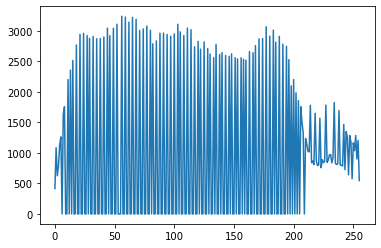

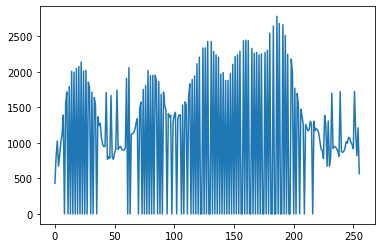

In [98]:
#colab code test on jupyter nb

def histogram_equalisation(input_image):

  def check_grey_scale(img_path):
    img = cv2.imread(img_path)
    w, h, c= img.shape
    for i in range(w):
        for j in range(h):
            r, g, b = img[i,j,:]
            if r != g != b: 
                return False
    return True

  def hist_equalize(oldimg):
    newimg=np.ones(oldimg.shape,dtype=np.int8)*-1
    oldhist=cv2.calcHist([oldimg],[0],None,[256],[0,256])
    oldhist=oldhist/oldhist.sum()
    oldhist=np.cumsum(oldhist) * (len(oldhist)-1)
    oldhist=np.round_(oldhist)
    oldhist=oldhist.astype(np.uint8)
    dict1={}
    for i in range(len(oldhist)):
      dict1[i]=oldhist[i]
    for key,val in dict1.items():
      newimg[oldimg==key]=val
    return newimg.astype(np.uint8)

  #for grey img
  if check_grey_scale(input_image) == True:
    greyimg=cv2.imread(input_image,0)
    output=hist_equalize(greyimg)

  #for colour img
  if check_grey_scale(input_image) == False:
    RGBimg=cv2.imread(input_image,1)
    Bimg= RGBimg[:,:,0]
    Gimg= RGBimg[:,:,1]
    Rimg= RGBimg[:,:,2]
    Boutput=hist_equalize(Bimg)
    Goutput=hist_equalize(Gimg)
    Routput=hist_equalize(Rimg)
    output=np.dstack((Boutput,Goutput,Routput))

  return output


ip=cv2.imread('Lena.png',0)
op=histogram_equalisation('Lena.png')

# cv2_imshow(ip)
# cv2_imshow(op)
iphist=cv2.calcHist([ip],[0],None,[256],[0,256])
ophist=cv2.calcHist([op],[0],None,[256],[0,256])
# fig, axs=plt.subplots(2)
# axs[0].plot(iphist)
# axs[1].plot(ophist)
plt.plot(ophist)
plt.show()


#INBUIT FUNC TO CHECK HISTOGRAM EQUALIZATION
equ = cv2.equalizeHist(ip)
ophist=cv2.calcHist([equ],[0],None,[256],[0,256])
plt.plot(ophist)
plt.show()